In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
import datetime as dt

import time
start = time.time()

In [165]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [166]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999046 entries, 0 to 1999045
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 30.5 MB


In [167]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
1999041    0.16
1999042    0.16
1999043    0.17
1999044    0.16
1999045    0.16
Name: kWh, Length: 1999046, dtype: float64

In [168]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
1999041    0.16
1999042    0.16
1999043    0.17
1999044    0.16
1999045    0.16
Name: kWh, Length: 1999046, dtype: float64

In [169]:
l=len(conso_data)-1
l

1999045

### conversion Interval -> kWh

In [170]:
conso_data['sec']=conso_data['Interval']/1000


In [171]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [172]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [173]:
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999046 entries, 0 to 1999045
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Interval   int64  
 1   kWh        float64
 2   sec        float64
 3   Wh         float64
 4   cumul(ms)  int64  
dtypes: float64(3), int64(2)
memory usage: 76.3 MB


In [174]:
conso_data.tail()

,Interval,kWh,sec,Wh,cumul(ms)
1999041,22109,0.16,22.109,162.829617,48905638556
1999042,21891,0.16,21.891,164.451144,48905660447
1999043,21529,0.17,21.529,167.216313,48905681976
1999044,22386,0.16,22.386,160.814795,48905704362
1999045,22415,0.16,22.415,160.606737,48905726777


In [175]:
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

48905726777000

### Calcul de la date de base = now - cumul_interval

In [176]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2023, 8, 21, 21, 28, 16, 74134)

In [177]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [178]:
conso_data.iloc[0]


Interval     21934.00000
kWh              0.16000
sec             21.93400
Wh             164.12875
cumul(ms)    21934.00000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [179]:
base

datetime.datetime(2023, 8, 21, 21, 28, 16, 74134)

## créer les dates

In [180]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0         2023-08-21 21:28:38.008134
1         2023-08-21 21:28:59.866134
2         2023-08-21 21:29:21.867134
3         2023-08-21 21:29:43.795134
4         2023-08-21 21:30:05.686134
                     ...            
1999041   2025-03-09 22:22:14.630134
1999042   2025-03-09 22:22:36.521134
1999043   2025-03-09 22:22:58.050134
1999044   2025-03-09 22:23:20.436134
1999045   2025-03-09 22:23:42.851134
Name: dates, Length: 1999046, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [181]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:28:38.008134,21/08/23
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:28:59.866134,21/08/23
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:29:21.867134,21/08/23
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:29:43.795134,21/08/23
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:30:05.686134,21/08/23
...,...,...,...,...,...,...,...
1999041,22109,0.16,22.109,162.829617,48905638556,2025-03-09 22:22:14.630134,09/03/25
1999042,21891,0.16,21.891,164.451144,48905660447,2025-03-09 22:22:36.521134,09/03/25
1999043,21529,0.17,21.529,167.216313,48905681976,2025-03-09 22:22:58.050134,09/03/25
1999044,22386,0.16,22.386,160.814795,48905704362,2025-03-09 22:23:20.436134,09/03/25


### save conso_data with dates

In [182]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [183]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
today, date, month, year


('09/03/25', 9, 3, 2025)

In [184]:
here = now.strftime('%H:%M:%S')
here

'22:24:18'

In [185]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [186]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4136 entries, 1994910 to 1999045
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   4136 non-null   int64         
 1   kWh        4136 non-null   float64       
 2   sec        4136 non-null   float64       
 3   Wh         4136 non-null   float64       
 4   cumul(ms)  4136 non-null   int64         
 5   dates      4136 non-null   datetime64[ns]
 6   days       4136 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 258.5+ KB


### grouped by days

In [187]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [188]:
data = list(df_grp['kWh'])
print(data)

[0.531, 3.689, 4.24, 3.687, 3.924, 4.582, 3.76, 3.463, 3.507, 3.699, 3.374, 4.197, 4.167, 3.726, 3.631, 3.63, 3.317, 3.384, 4.058, 4.017, 3.998, 4.13, 3.515, 4.208, 3.998, 3.746, 4.081, 4.601, 4.179, 3.222, 3.17, 3.864, 3.811, 3.073, 3.78, 4.132, 3.645, 3.734, 4.553, 4.327, 4.412, 3.898, 3.446, 4.269, 3.934, 3.743, 3.568, 3.935, 3.765, 3.473, 4.089, 3.41, 3.826, 3.888, 3.595, 3.722, 4.343, 3.247, 3.879, 3.181, 2.055, 2.049, 2.266, 4.094, 3.627, 4.308, 3.628, 3.99, 3.788, 3.692, 4.18, 3.984, 3.809, 3.145, 3.741, 3.593, 3.547, 3.681, 3.706, 3.341, 3.778, 3.281, 3.757, 3.586, 4.069, 3.575, 3.55, 3.66, 4.042, 4.403, 3.93, 4.062, 4.341, 3.838, 3.862, 3.821, 3.79, 3.828, 4.07, 4.426, 3.831, 3.536, 3.68, 3.684, 3.344, 3.835, 3.795, 4.308, 3.528, 4.16, 3.542, 3.929, 4.7, 3.58, 3.604, 3.515, 3.942, 3.891, 4.146, 3.855, 3.83, 3.632, 4.987, 3.833, 3.678, 4.209, 4.264, 4.316, 4.552, 4.148, 3.663, 4.46, 4.702, 4.089, 4.737, 4.517, 3.666, 4.029, 3.928, 3.618, 3.565, 3.956, 3.655, 3.716, 3.632, 3.493

In [189]:
# save to file
import pickle
path = r'kwh_mean.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

### plot function by day
#### show('dd/mm/yy')

In [190]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


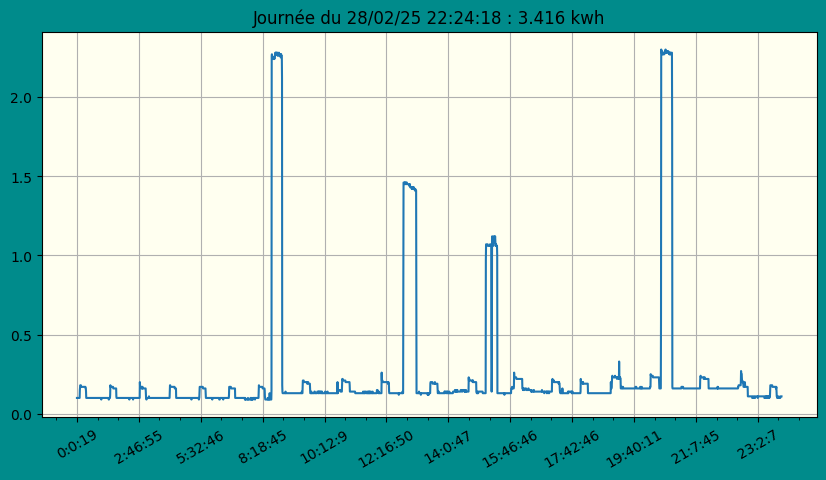

In [191]:
show('28/02/25')

### 1 kWh window in data of one day
#### df = conso_day

In [192]:
df = conso_day

In [193]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [194]:
df = conso_day
len(df)

4136

In [195]:
period()  # first kWh

2025-03-09 00:00:24.087134	2025-03-09 08:23:39.903134	8h 23m 15s 	1000


In [196]:
period(p=2) # second period

2025-03-09 08:23:39.903134	2025-03-09 13:32:46.451134	5h 9m 6s 	2000


In [197]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.301717
dtype: float64

### mean for data grouped by days

In [198]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.525654
dtype: float64

In [199]:
last=df_grp.iloc[-1]['kWh']
last

4.136

In [200]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4136 entries, 1994910 to 1999045
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   4136 non-null   int64         
 1   kWh        4136 non-null   float64       
 2   sec        4136 non-null   float64       
 3   Wh         4136 non-null   float64       
 4   cumul(ms)  4136 non-null   int64         
 5   dates      4136 non-null   datetime64[ns]
 6   days       4136 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 258.5+ KB


# conso by date


In [201]:
# select day
day = today

#day = '16/08/24'
day

'09/03/25'

In [202]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
1994910,25993,0.14,25.993,138.498827,48825128013,2025-03-09 00:00:24.087134,09/03/25
1994911,25762,0.14,25.762,139.740703,48825153775,2025-03-09 00:00:49.849134,09/03/25
1994912,24767,0.14,24.767,145.354706,48825178542,2025-03-09 00:01:14.616134,09/03/25
1994913,26006,0.14,26.006,138.429593,48825204548,2025-03-09 00:01:40.622134,09/03/25
1994914,26083,0.14,26.083,138.020933,48825230631,2025-03-09 00:02:06.705134,09/03/25
...,...,...,...,...,...,...,...
1999041,22109,0.16,22.109,162.829617,48905638556,2025-03-09 22:22:14.630134,09/03/25
1999042,21891,0.16,21.891,164.451144,48905660447,2025-03-09 22:22:36.521134,09/03/25
1999043,21529,0.17,21.529,167.216313,48905681976,2025-03-09 22:22:58.050134,09/03/25
1999044,22386,0.16,22.386,160.814795,48905704362,2025-03-09 22:23:20.436134,09/03/25


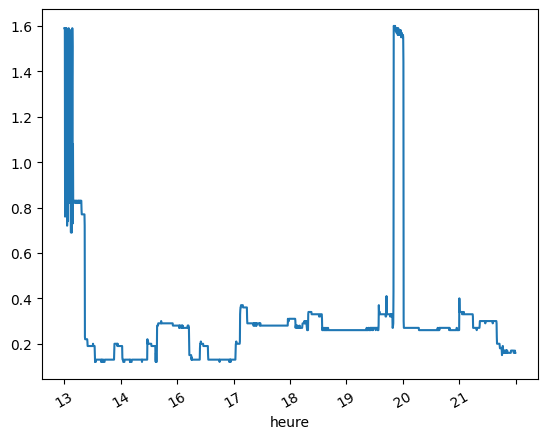

In [203]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


### grouped by 'heure'

In [204]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4136 entries, 1994910 to 1999045
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   4136 non-null   int64         
 1   kWh        4136 non-null   float64       
 2   sec        4136 non-null   float64       
 3   Wh         4136 non-null   float64       
 4   cumul(ms)  4136 non-null   int64         
 5   dates      4136 non-null   datetime64[ns]
 6   days       4136 non-null   object        
 7   heure      4136 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 290.8+ KB


In [205]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0,25993,0.14,25.993,138.498827,48825128013,2025-03-09 00:00:24.087134,09/03/25
0,25762,0.14,25.762,139.740703,48825153775,2025-03-09 00:00:49.849134,09/03/25
0,24767,0.14,24.767,145.354706,48825178542,2025-03-09 00:01:14.616134,09/03/25
0,26006,0.14,26.006,138.429593,48825204548,2025-03-09 00:01:40.622134,09/03/25
0,26083,0.14,26.083,138.020933,48825230631,2025-03-09 00:02:06.705134,09/03/25
...,...,...,...,...,...,...,...
22,22109,0.16,22.109,162.829617,48905638556,2025-03-09 22:22:14.630134,09/03/25
22,21891,0.16,21.891,164.451144,48905660447,2025-03-09 22:22:36.521134,09/03/25
22,21529,0.17,21.529,167.216313,48905681976,2025-03-09 22:22:58.050134,09/03/25


In [206]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [207]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     142
1     119
2     118
3     107
4     119
5     118
6     118
7     117
8     104
9     189
10    145
11    142
12    140
13    594
14    140
15    151
16    211
17    135
18    290
19    276
20    315
21    280
22     66
Name: kWh, dtype: int64

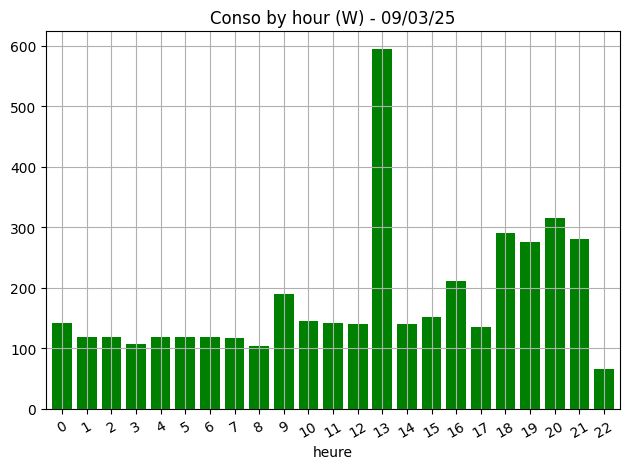

In [208]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [209]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 567 entries, 21/08/23 to 09/03/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     567 non-null    float64
dtypes: float64(1)
memory usage: 8.9+ KB


In [210]:
period()

2025-03-09 00:00:24.087134	2025-03-09 08:23:39.903134	8h 23m 15s 	1000


In [211]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates
df.dates.dt.time


heure
0     00:00:24.087134
0     00:00:49.849134
0     00:01:14.616134
0     00:01:40.622134
0     00:02:06.705134
           ...       
22    22:22:14.630134
22    22:22:36.521134
22    22:22:58.050134
22    22:23:20.436134
22    22:23:42.851134
Name: dates, Length: 4136, dtype: object

In [212]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
df_grp


,kWh
days,
21/08/23,0.531
22/08/23,3.689
23/08/23,4.240
24/08/23,3.687
25/08/23,3.924
...,...
05/03/25,3.842
06/03/25,4.168
07/03/25,3.343


In [213]:
df_grp.mean()


kWh    3.525654
dtype: float64

In [214]:
df_grp.head()


,kWh
days,
21/08/23,0.531
22/08/23,3.689
23/08/23,4.240
24/08/23,3.687
25/08/23,3.924


In [215]:
df_grp.tail()


,kWh
days,
05/03/25,3.842
06/03/25,4.168
07/03/25,3.343
08/03/25,3.426
09/03/25,4.136


# plot les 100 derniers jours


In [216]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.6917
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

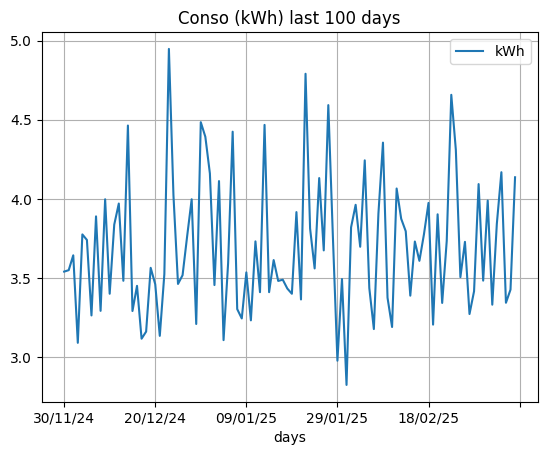

In [217]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.grid()
plt.title('Conso (kWh) last 100 days')


In [218]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,2.824
max,4.947


Text(0.5, 1.0, 'Last month conso by day')

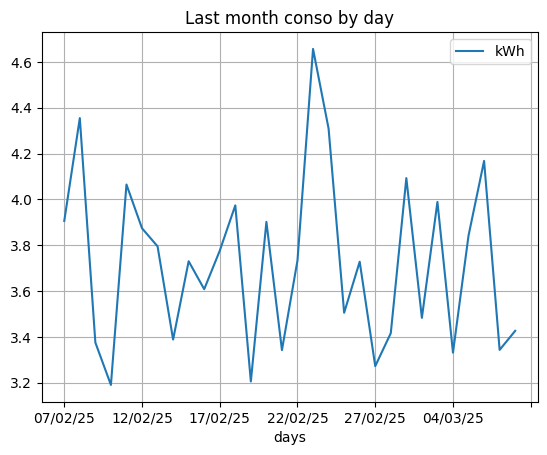

In [219]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.grid()
plt.title('Last month conso by day')


In [220]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 23/02/25 4.657
Min : 10/02/25 3.19


In [221]:

tranches = len(df)//1000
tranches+1
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p=p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


2025-03-09 00:00:24.087134	2025-03-09 08:23:39.903134	8h 23m 15s 	1000
2025-03-09 08:23:39.903134	2025-03-09 13:32:46.451134	5h 9m 6s 	2000
2025-03-09 13:32:46.451134	2025-03-09 18:17:56.745134	4h 45m 10s 	3000
2025-03-09 18:17:56.745134	2025-03-09 21:43:54.927134	3h 25m 58s 	4000
2025-03-09 21:43:54.927134	2025-03-09 22:23:42.851134	0h 39m 47s 	136


('22:24:18', 4.136, 4136)

In [222]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4136 entries, 1994910 to 1999045
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   4136 non-null   int64         
 1   kWh        4136 non-null   float64       
 2   sec        4136 non-null   float64       
 3   Wh         4136 non-null   float64       
 4   cumul(ms)  4136 non-null   int64         
 5   dates      4136 non-null   datetime64[ns]
 6   days       4136 non-null   object        
 7   heure      4136 non-null   object        
 8   hours      4136 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 323.1+ KB


In [223]:
conso_hours['heure'], conso_hours['hours']

(1994910     0
 1994911     0
 1994912     0
 1994913     0
 1994914     0
            ..
 1999041    22
 1999042    22
 1999043    22
 1999044    22
 1999045    22
 Name: heure, Length: 4136, dtype: object,
 1994910    00
 1994911    00
 1994912    00
 1994913    00
 1994914    00
            ..
 1999041    22
 1999042    22
 1999043    22
 1999044    22
 1999045    22
 Name: hours, Length: 4136, dtype: object)

In [224]:
# select number of days to display
span = 30
#df_grp.tail(span)


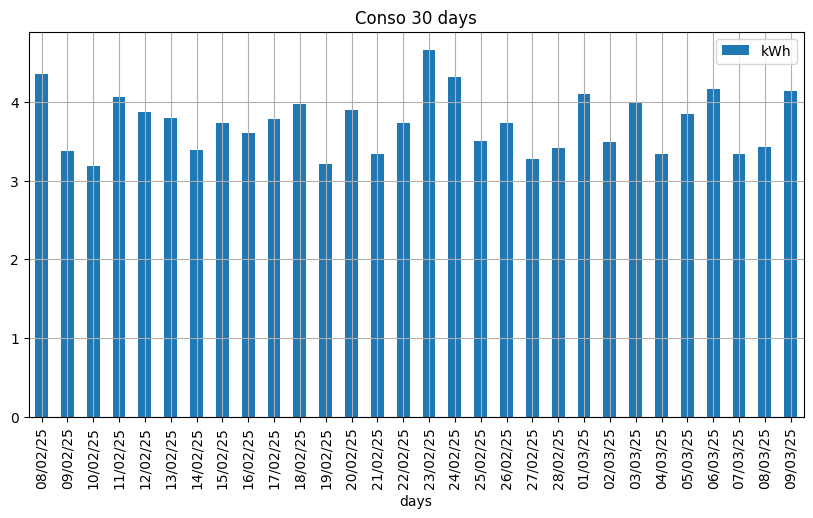

In [225]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


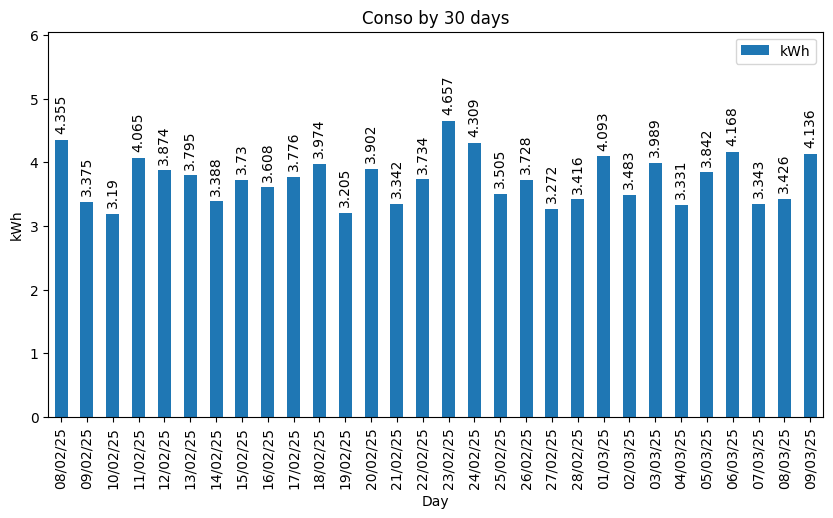

In [226]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [227]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
08/02/25    4.355
09/02/25    3.375
10/02/25    3.190
11/02/25    4.065
12/02/25    3.874
13/02/25    3.795
14/02/25    3.388
15/02/25    3.730
16/02/25    3.608
17/02/25    3.776
18/02/25    3.974
19/02/25    3.205
20/02/25    3.902
21/02/25    3.342
22/02/25    3.734
23/02/25    4.657
24/02/25    4.309
25/02/25    3.505
26/02/25    3.728
27/02/25    3.272
28/02/25    3.416
01/03/25    4.093
02/03/25    3.483
03/03/25    3.989
04/03/25    3.331
05/03/25    3.842
06/03/25    4.168
07/03/25    3.343
08/03/25    3.426
09/03/25    4.136
Name: kWh, dtype: float64

In [228]:
x_labels=df_grp.tail(span).index
x_labels

Index(['08/02/25', '09/02/25', '10/02/25', '11/02/25', '12/02/25', '13/02/25',
       '14/02/25', '15/02/25', '16/02/25', '17/02/25', '18/02/25', '19/02/25',
       '20/02/25', '21/02/25', '22/02/25', '23/02/25', '24/02/25', '25/02/25',
       '26/02/25', '27/02/25', '28/02/25', '01/03/25', '02/03/25', '03/03/25',
       '04/03/25', '05/03/25', '06/03/25', '07/03/25', '08/03/25', '09/03/25'],
      dtype='object', name='days')

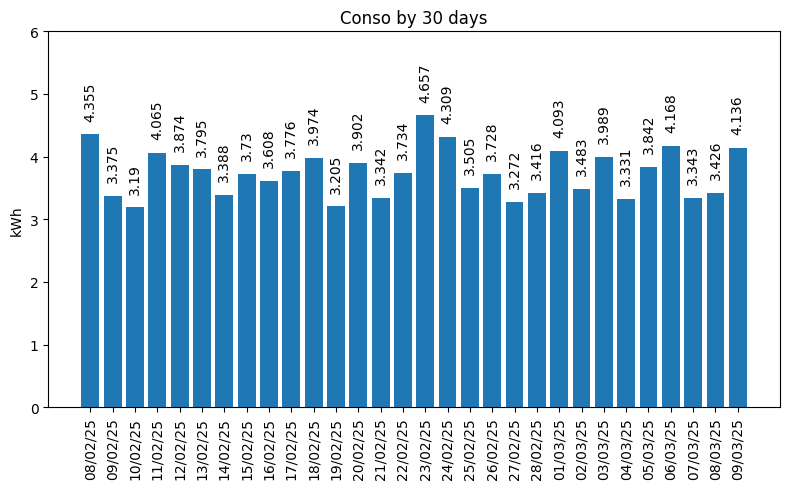

In [229]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [230]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

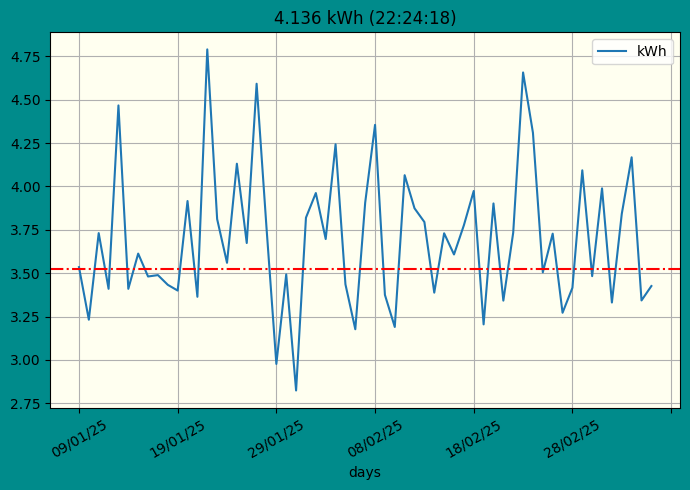

In [231]:
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

# 2 last months
df_grp.iloc[-60:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

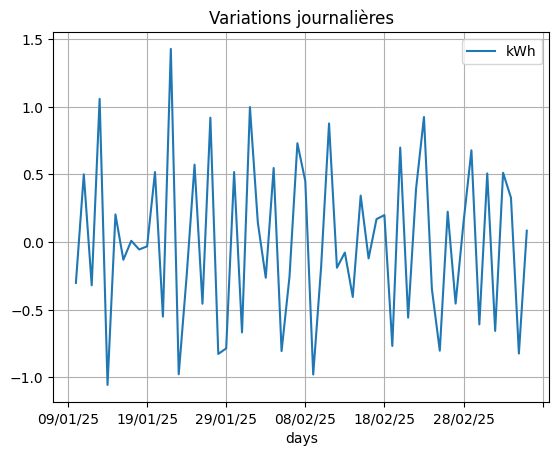

In [232]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

# Data from 21/08/23

In [233]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')


In [234]:
conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:28:38.008134,21/08/23,21,2023-08,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:28:59.866134,21/08/23,21,2023-08,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:29:21.867134,21/08/23,21,2023-08,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:29:43.795134,21/08/23,21,2023-08,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:30:05.686134,21/08/23,21,2023-08,21
...,...,...,...,...,...,...,...,...,...,...
1999041,22109,0.16,22.109,162.829617,48905638556,2025-03-09 22:22:14.630134,09/03/25,22,2025-03,09
1999042,21891,0.16,21.891,164.451144,48905660447,2025-03-09 22:22:36.521134,09/03/25,22,2025-03,09
1999043,21529,0.17,21.529,167.216313,48905681976,2025-03-09 22:22:58.050134,09/03/25,22,2025-03,09
1999044,22386,0.16,22.386,160.814795,48905704362,2025-03-09 22:23:20.436134,09/03/25,22,2025-03,09


In [235]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)


In [236]:
conso_grouped_by_month.groups.keys()

dict_keys(['2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03'])

In [237]:
month=conso_grouped_by_month.get_group('2024-11')

In [238]:
conso_grouped_by_month_day = month.groupby(['day'], sort=False)

In [239]:
conso_grouped_by_month_day.count()


,hours,months,kWh
day,,,
01,3294,3294,3294
02,4132,4132,4132
03,3069,3069,3069
04,4074,4074,4074
05,3091,3091,3091
06,3412,3412,3412
07,3515,3515,3515
08,3961,3961,3961
09,3312,3312,3312


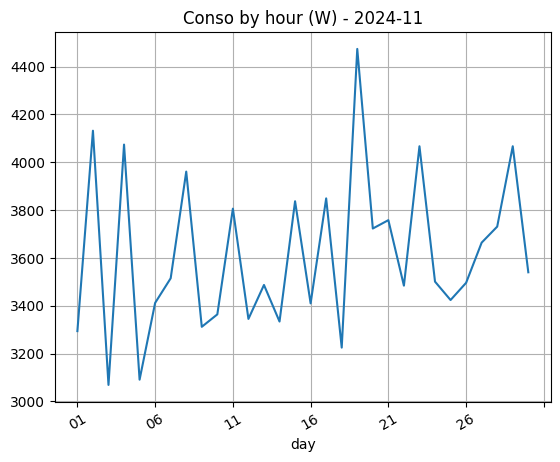

In [240]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
plt.title('Conso by hour (W) - '+month.iloc[0]['months'])
plt.xticks(rotation=30);


In [241]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

In [242]:
conso_grouped_by_month_day.count()

,hours,months,kWh
day,,,
01,3294,3294,3294
02,4132,4132,4132
03,3069,3069,3069
04,4074,4074,4074
05,3091,3091,3091
06,3412,3412,3412
07,3515,3515,3515
08,3961,3961,3961
09,3312,3312,3312


In [243]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [244]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [245]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2023-08,38456,38456,38456
2023-09,116306,116306,116306
2023-10,112872,112872,112872
2023-11,113599,113599,113599
2023-12,123312,123312,123312
2024-01,119512,119512,119512
2024-02,108751,108751,108751
2024-03,114281,114281,114281
2024-04,109920,109920,109920


In [246]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [247]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [248]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
21/08/23,531
22/08/23,3689
23/08/23,4240
24/08/23,3687
25/08/23,3924
...,...
05/03/25,3842
06/03/25,4168
07/03/25,3343


In [249]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:28:38.008134,21/08/23,21,2023-08,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:28:59.866134,21/08/23,21,2023-08,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:29:21.867134,21/08/23,21,2023-08,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:29:43.795134,21/08/23,21,2023-08,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:30:05.686134,21/08/23,21,2023-08,21
...,...,...,...,...,...,...,...,...,...,...
1999041,22109,0.16,22.109,162.829617,48905638556,2025-03-09 22:22:14.630134,09/03/25,22,2025-03,09
1999042,21891,0.16,21.891,164.451144,48905660447,2025-03-09 22:22:36.521134,09/03/25,22,2025-03,09
1999043,21529,0.17,21.529,167.216313,48905681976,2025-03-09 22:22:58.050134,09/03/25,22,2025-03,09
1999044,22386,0.16,22.386,160.814795,48905704362,2025-03-09 22:23:20.436134,09/03/25,22,2025-03,09


In [250]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                              
21/08/23 21    0        21/08/23    21  0.16
               1        21/08/23    21  0.16
               2        21/08/23    21  0.16
               3        21/08/23    21  0.16
               4        21/08/23    21  0.16
...                          ...   ...   ...
09/03/25 22    1999041  09/03/25    22  0.16
               1999042  09/03/25    22  0.16
               1999043  09/03/25    22  0.17
               1999044  09/03/25    22  0.16
               1999045  09/03/25    22  0.16

[1999046 rows x 3 columns]

In [251]:
groupallbyday.indices.keys()

dict_keys(['21/08/23', '22/08/23', '23/08/23', '24/08/23', '25/08/23', '26/08/23', '27/08/23', '28/08/23', '29/08/23', '30/08/23', '31/08/23', '01/09/23', '02/09/23', '03/09/23', '04/09/23', '05/09/23', '06/09/23', '07/09/23', '08/09/23', '09/09/23', '10/09/23', '11/09/23', '12/09/23', '13/09/23', '14/09/23', '15/09/23', '16/09/23', '17/09/23', '18/09/23', '19/09/23', '20/09/23', '21/09/23', '22/09/23', '23/09/23', '24/09/23', '25/09/23', '26/09/23', '27/09/23', '28/09/23', '29/09/23', '30/09/23', '01/10/23', '02/10/23', '03/10/23', '04/10/23', '05/10/23', '06/10/23', '07/10/23', '08/10/23', '09/10/23', '10/10/23', '11/10/23', '12/10/23', '13/10/23', '14/10/23', '15/10/23', '16/10/23', '17/10/23', '18/10/23', '19/10/23', '20/10/23', '21/10/23', '22/10/23', '23/10/23', '24/10/23', '25/10/23', '26/10/23', '27/10/23', '28/10/23', '29/10/23', '30/10/23', '31/10/23', '01/11/23', '02/11/23', '03/11/23', '04/11/23', '05/11/23', '06/11/23', '07/11/23', '08/11/23', '09/11/23', '10/11/23', '11/1

In [252]:
groupallbydayhours.indices.keys()

dict_keys([('21/08/23', '21'), ('21/08/23', '22'), ('21/08/23', '23'), ('22/08/23', '21'), ('22/08/23', '22'), ('22/08/23', '23'), ('22/08/23', '00'), ('22/08/23', '01'), ('22/08/23', '02'), ('22/08/23', '03'), ('22/08/23', '04'), ('22/08/23', '05'), ('22/08/23', '06'), ('22/08/23', '07'), ('22/08/23', '08'), ('22/08/23', '09'), ('22/08/23', '10'), ('22/08/23', '11'), ('22/08/23', '12'), ('22/08/23', '13'), ('22/08/23', '14'), ('22/08/23', '15'), ('22/08/23', '16'), ('22/08/23', '17'), ('22/08/23', '18'), ('22/08/23', '19'), ('22/08/23', '20'), ('23/08/23', '21'), ('23/08/23', '22'), ('23/08/23', '23'), ('23/08/23', '00'), ('23/08/23', '01'), ('23/08/23', '02'), ('23/08/23', '03'), ('23/08/23', '04'), ('23/08/23', '05'), ('23/08/23', '06'), ('23/08/23', '07'), ('23/08/23', '08'), ('23/08/23', '09'), ('23/08/23', '10'), ('23/08/23', '11'), ('23/08/23', '12'), ('23/08/23', '13'), ('23/08/23', '14'), ('23/08/23', '15'), ('23/08/23', '16'), ('23/08/23', '17'), ('23/08/23', '18'), ('23/08/2

In [253]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
21/08/23,531,531
22/08/23,3689,3689
23/08/23,4240,4240
24/08/23,3687,3687
25/08/23,3924,3924
...,...,...
05/03/25,3842,3842
06/03/25,4168,4168
07/03/25,3343,3343


In [254]:
grp_by_day['kWh'].cumsum()

days
21/08/23        531
22/08/23       4220
23/08/23       8460
24/08/23      12147
25/08/23      16071
             ...   
05/03/25    1983973
06/03/25    1988141
07/03/25    1991484
08/03/25    1994910
09/03/25    1999046
Name: kWh, Length: 567, dtype: int64

In [255]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
21/08/23 21      97
         22     282
         23     152
22/08/23 00     129
         01     130
...             ...
09/03/25 18     290
         19     276
         20     315
         21     280
         22      66

[13586 rows x 1 columns]

In [256]:
grp_by_dayhours['kWh'].cumsum()

days      hours
21/08/23  21            97
          22           379
          23           531
22/08/23  00           660
          01           790
                    ...   
09/03/25  18       1998109
          19       1998385
          20       1998700
          21       1998980
          22       1999046
Name: kWh, Length: 13586, dtype: int64

In [257]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
21/08/23 21      97      97    NaN
         22     282     379  185.0
         23     152     531 -130.0
22/08/23 00     129     129    NaN
         01     130     259    1.0
...             ...     ...    ...
09/03/25 18     290    3199  155.0
         19     276    3475  -14.0
         20     315    3790   39.0
         21     280    4070  -35.0
         22      66    4136 -214.0

[13586 rows x 3 columns]

In [258]:
today, grp_by_dayhours.loc[today]

('09/03/25',
        kWh  cumsum   diff
 hours                    
 00     142     142    NaN
 01     119     261  -23.0
 02     118     379   -1.0
 03     107     486  -11.0
 04     119     605   12.0
 05     118     723   -1.0
 06     118     841    0.0
 07     117     958   -1.0
 08     104    1062  -13.0
 09     189    1251   85.0
 10     145    1396  -44.0
 11     142    1538   -3.0
 12     140    1678   -2.0
 13     594    2272  454.0
 14     140    2412 -454.0
 15     151    2563   11.0
 16     211    2774   60.0
 17     135    2909  -76.0
 18     290    3199  155.0
 19     276    3475  -14.0
 20     315    3790   39.0
 21     280    4070  -35.0
 22      66    4136 -214.0)

Text(0.5, 1.0, 'Cumul journalier')

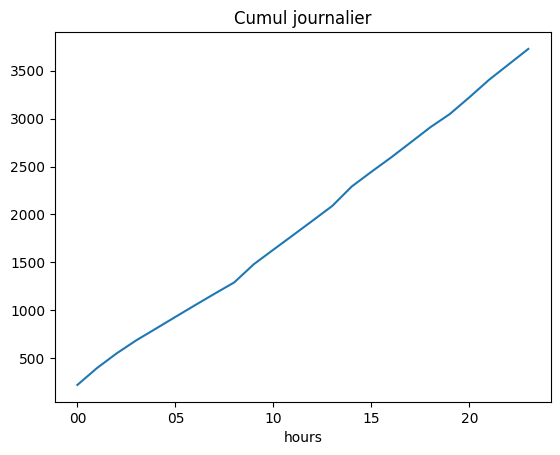

In [259]:
# progression sans surprise
grp_by_dayhours.loc['26/08/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

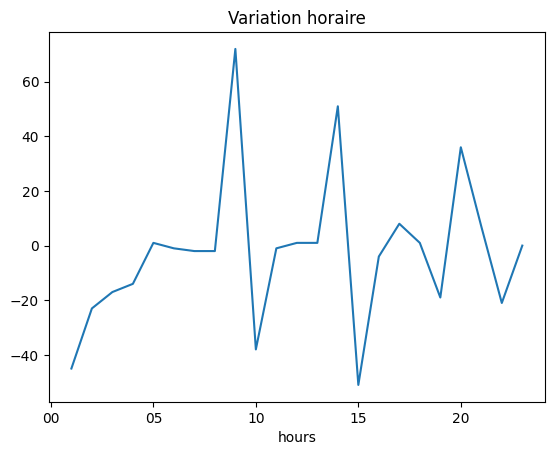

In [260]:
# plus parlant
grp_by_dayhours.loc['26/08/24']['diff'].plot()
plt.title(r'Variation horaire')

In [261]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

567

In [262]:
df_grp.tail(n)['kWh'].describe()


count    567.000000
mean       3.525654
std        0.661953
min        0.531000
25%        3.349000
50%        3.630000
75%        3.892500
max        4.987000
Name: kWh, dtype: float64

In [263]:
maxday = df_grp.tail(n)['kWh'].idxmax()

Text(0.5, 1.0, '567 days')

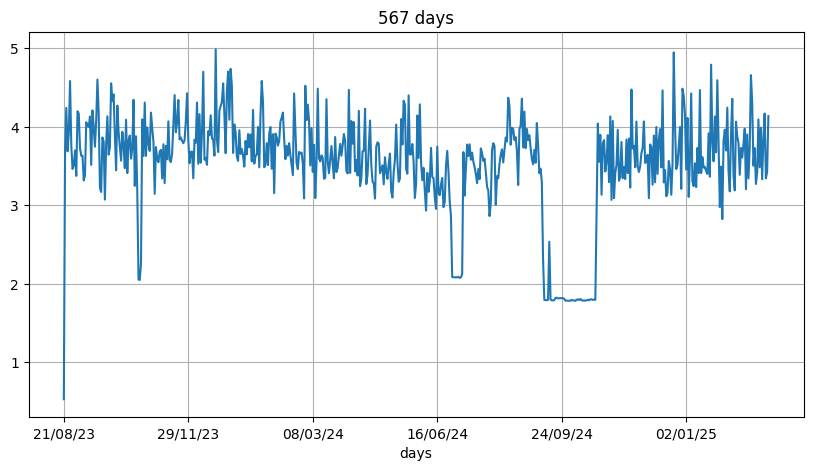

In [264]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

Text(0.5, 1.0, '400 days')

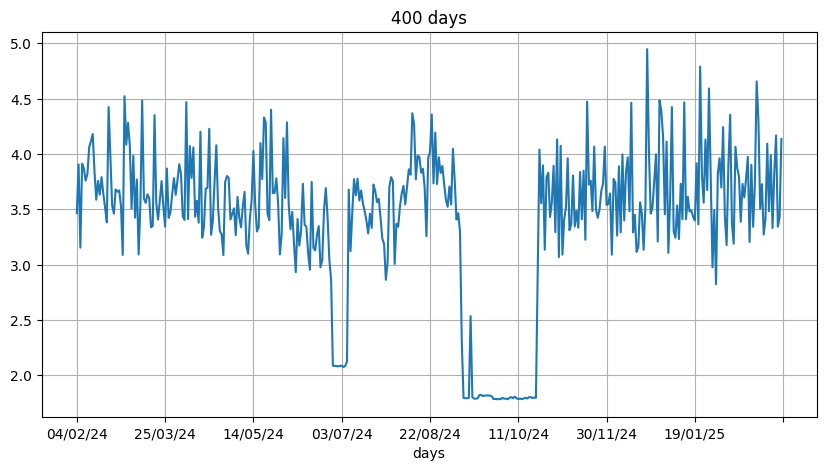

In [265]:
# show conso in span 
span = 400
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

In [266]:
df_grp['kWh']

days
21/08/23    0.531
22/08/23    3.689
23/08/23    4.240
24/08/23    3.687
25/08/23    3.924
            ...  
05/03/25    3.842
06/03/25    4.168
07/03/25    3.343
08/03/25    3.426
09/03/25    4.136
Name: kWh, Length: 567, dtype: float64

In [267]:
df_grp.describe()

,kWh
count,567.000000
mean,3.525654
std,0.661953
min,0.531000
25%,3.349000
50%,3.630000
75%,3.892500
max,4.987000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

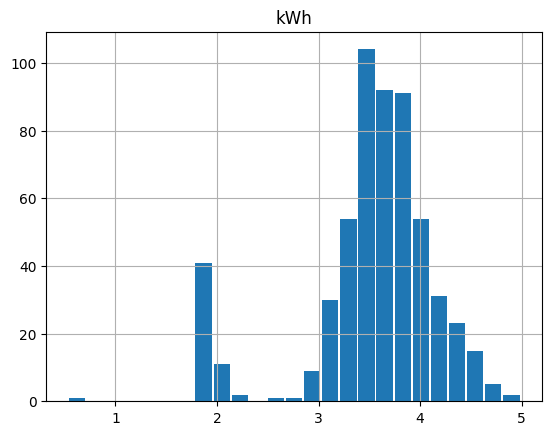

In [268]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [269]:
df_grp.tail(span)['kWh']

days
04/02/24    3.465
05/02/24    3.905
06/02/24    3.154
07/02/24    3.913
08/02/24    3.870
            ...  
05/03/25    3.842
06/03/25    4.168
07/03/25    3.343
08/03/25    3.426
09/03/25    4.136
Name: kWh, Length: 400, dtype: float64

# Conso par heure

In [270]:
day

'09/03/25'

In [271]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,142,142,NaN
01,119,261,-23.0
02,118,379,-1.0
03,107,486,-11.0
04,119,605,12.0
05,118,723,-1.0
06,118,841,0.0
07,117,958,-1.0
08,104,1062,-13.0


In [272]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


23

In [273]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 24)

In [274]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [275]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [276]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
22    23.0
Name: days, dtype: float64

In [277]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [278]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 00 to 22
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     23 non-null     int64  
 1   cumsum  23 non-null     int64  
 2   diff    22 non-null     float64
 3   days    23 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 920.0+ bytes


In [279]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
22    23.0
Name: days, dtype: float64

In [280]:
day

'09/03/25'

In [281]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,142,142,NaN,1.0
01,119,261,-23.0,2.0
02,118,379,-1.0,3.0
03,107,486,-11.0,4.0
04,119,605,12.0,5.0
05,118,723,-1.0,6.0
06,118,841,0.0,7.0
07,117,958,-1.0,8.0
08,104,1062,-13.0,9.0


Text(0.5, 1.0, '09/03/25')

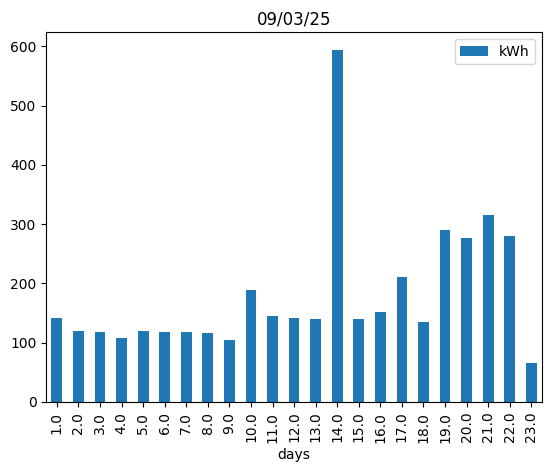

In [282]:
grp_by_dayhours.loc[day][['days','kWh']].plot.bar(x='days')
plt.title(f'{day}')

In [283]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22'],
      dtype='object', name='hours')

# Conso du jour


In [284]:

grp_by_dayhours.count()

kWh       13586
cumsum    13586
diff      13019
days         23
dtype: int64

In [285]:
day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh

hours
00    151
01    166
02    161
03    157
04    168
05    150
06    166
07    147
08    115
09    131
10    117
11    127
12    131
13    114
14    130
15    197
16    144
17    154
18    955
19    204
20    285
21    304
22    306
23    307
Name: kWh, dtype: int64

In [286]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

369.17

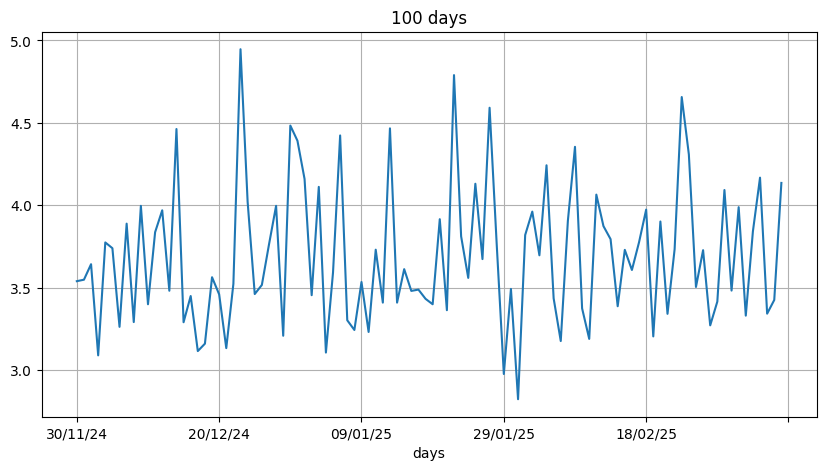

In [287]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])

In [288]:
df_grp.tail(1)

,kWh
days,
09/03/25,4.136


In [289]:
span = 1
#df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
#plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])

4.136

In [290]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

160.9007396697998


# Today

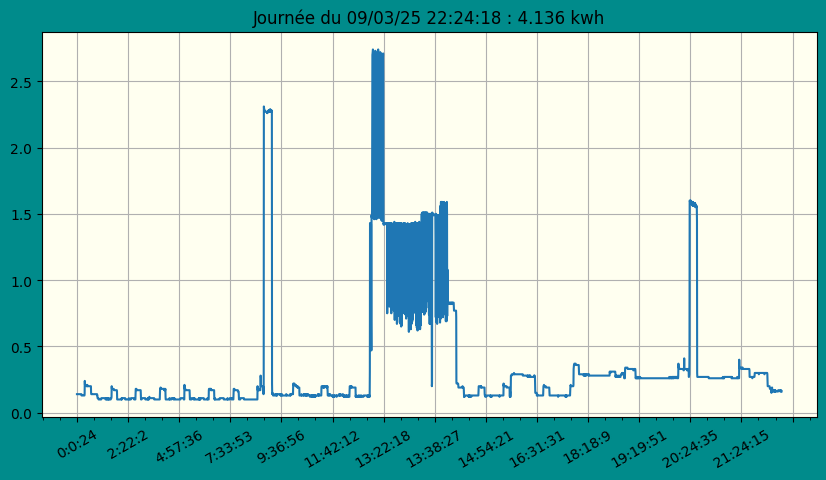

In [291]:
show(today,bgcolor='ivory')

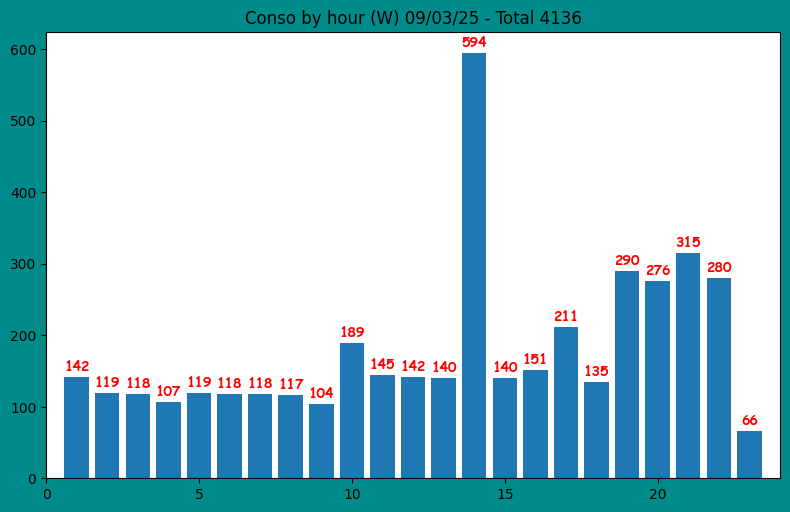

In [292]:
conso_by_hour(today)

In [293]:
day = '23/02/25'

('23/02/25', None)

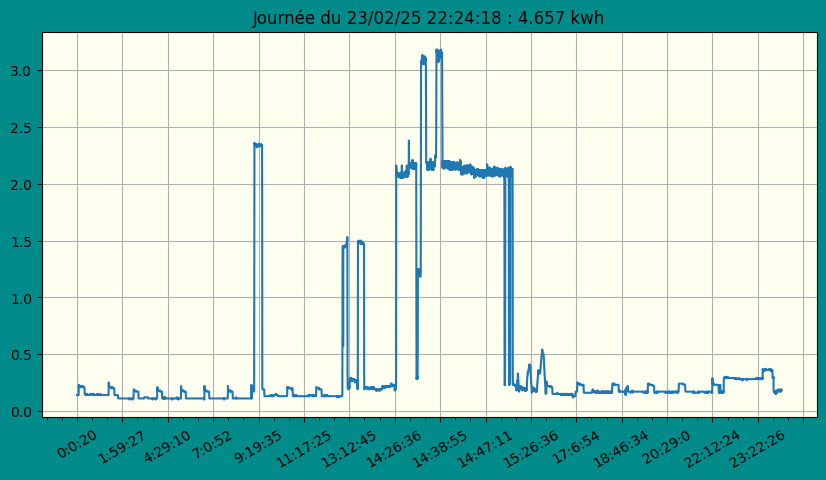

In [294]:
day, show(day,bgcolor='ivory')

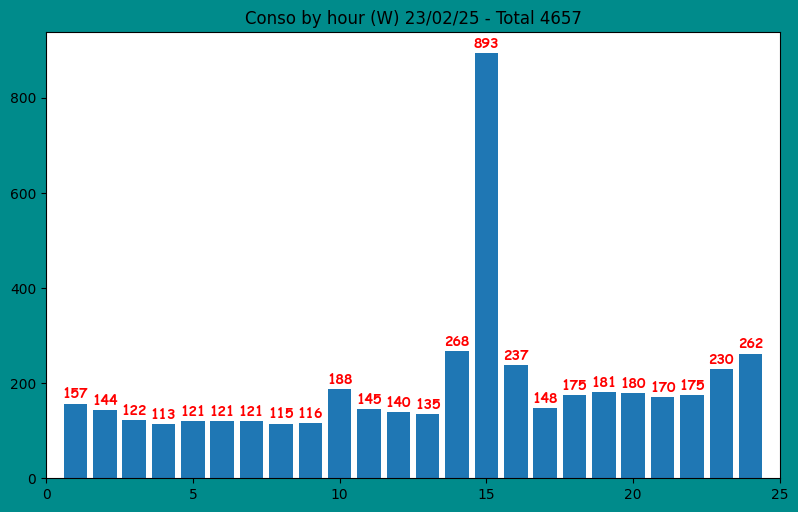

In [295]:
conso_by_hour(day)

In [296]:
maxday

'21/12/23'

('21/12/23', None)

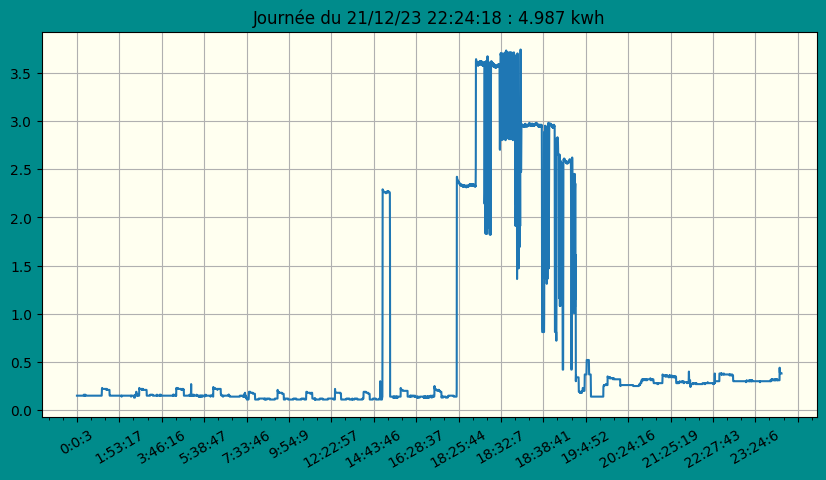

In [297]:
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')

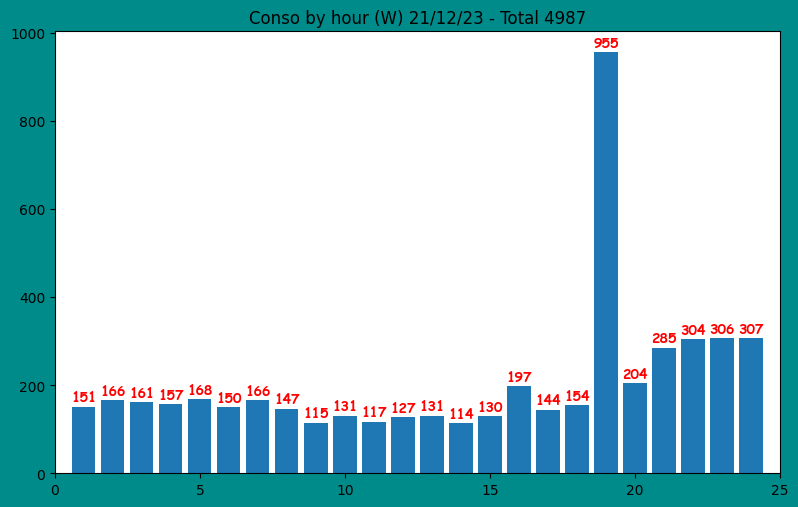

In [298]:
conso_by_hour(day)

In [299]:
sum(data)

4987

In [300]:
diff = grp_by_dayhours.loc[today]
diff


,kWh,cumsum,diff,days
hours,,,,
00,142,142,NaN,1.0
01,119,261,-23.0,2.0
02,118,379,-1.0,3.0
03,107,486,-11.0,4.0
04,119,605,12.0,5.0
05,118,723,-1.0,6.0
06,118,841,0.0,7.0
07,117,958,-1.0,8.0
08,104,1062,-13.0,9.0


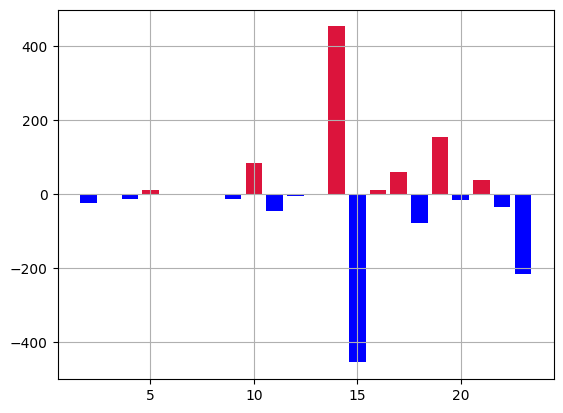

In [301]:
x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

In [302]:
data

hours
00    151
01    166
02    161
03    157
04    168
05    150
06    166
07    147
08    115
09    131
10    117
11    127
12    131
13    114
14    130
15    197
16    144
17    154
18    955
19    204
20    285
21    304
22    306
23    307
Name: kWh, dtype: int64

<Axes: xlabel='hours'>

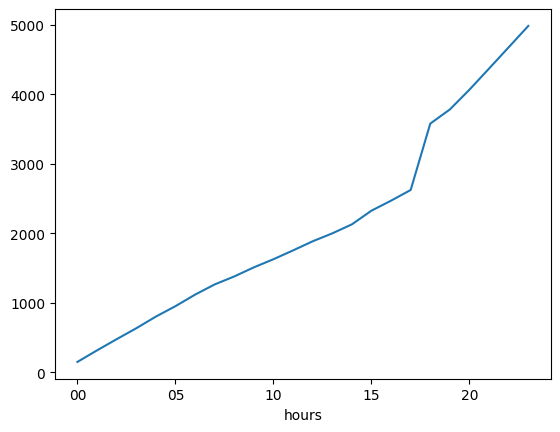

In [303]:
data.cumsum().plot()


<Axes: xlabel='hours'>

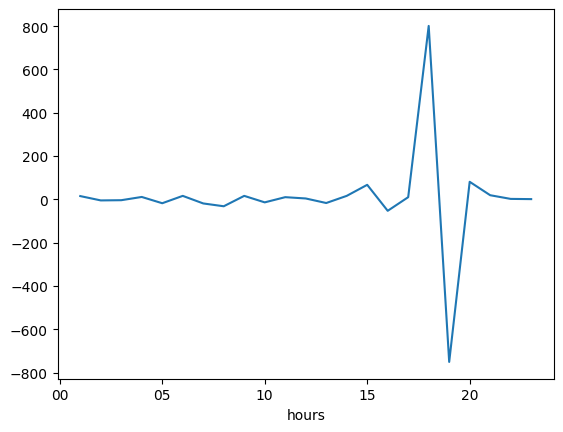

In [304]:
# evolution par heure
data.diff().plot()

In [305]:
data.diff().describe()

count     23.000000
mean       6.782609
std      235.713030
min     -751.000000
25%      -15.500000
50%        4.000000
75%       16.000000
max      801.000000
Name: kWh, dtype: float64

<Axes: >

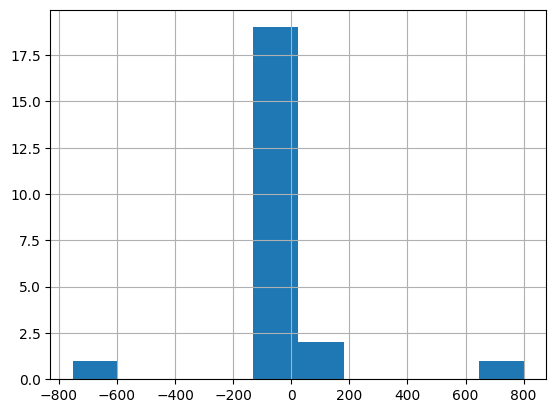

In [306]:
data.diff().hist()

# Test sauvegarde

In [307]:
import os
os.listdir(path='.')

['.git',
 '.gitignore',
 '.git_old',
 '.ipynb_checkpoints',
 '1row.flf',
 '5_days_meteo.ipynb',
 '8days.csv',
 '8days.pkl',
 '8days_dump.json',
 '8days_to_json.json',
 'advanced_expression.ipynb',
 'alphabeta_tree.ipynb',
 'amlich.ipynb',
 'amlich5.ipynb',
 'amlich5_test.ipynb',
 'amlich_data.py',
 'amlich_functions.py',
 'amlich_lib.py',
 'amlich_soc_tiet.ipynb',
 'AntPath.ipynb',
 'Apple.csv',
 'astronomie_def.ipynb',
 'atom_electronic_configuration.ipynb',
 'average_binding_energy_by_nucleons.ipynb',
 'bar_label.ipynb',
 'bell_curve.ipynb',
 'bitcoin_api.ipynb',
 'bitmap_convert.ipynb',
 'bitmap_structure.ipynb',
 'CAC40.csv',
 'chess_board.ipynb',
 'coindesk_api_client.ipynb',
 'collections.ipynb',
 'colormaps.ipynb',
 'conso.txt',
 'conso_by_hour.ipynb',
 'conso_data.csv',
 'conso_day_from_20230821.csv',
 'conso_jour.csv',
 'conso_jour.png',
 'conso_kwh.ipynb',
 'conso_kwh_reduced.ipynb',
 'conso_par_jour.csv',
 'covid19_france.ipynb',
 'cryptography_fernet.ipynb',
 'csv_readwrite

In [308]:
# list to store files
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

8days.csv
Apple.csv
CAC40.csv
conso_data.csv
conso_day_from_20230821.csv
conso_jour.csv
conso_par_jour.csv
data_temp16122022.csv
demain.csv
df.csv
df_grp.csv
DowJones.csv
EURUSD.csv
Ford.csv
karaoke.csv
ligue1_2020_27.csv
Nasdaq.csv
Nikkei.csv
planete.csv
saturn_bodies.csv
saturn_rings.csv
SMSSpamCollection.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
temp_humidity.csv
Tesla.csv
titanic.csv
Toyota.csv
VNDUSD.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
week.csv


In [309]:
#conso_byhour(day)

In [310]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


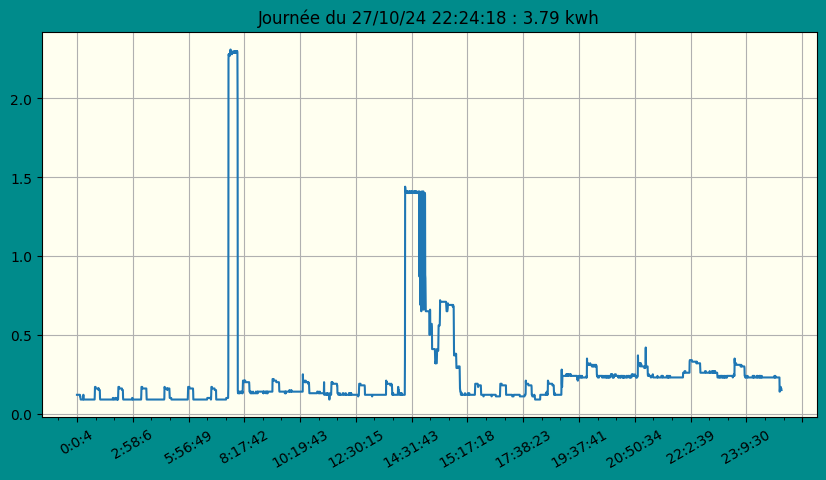

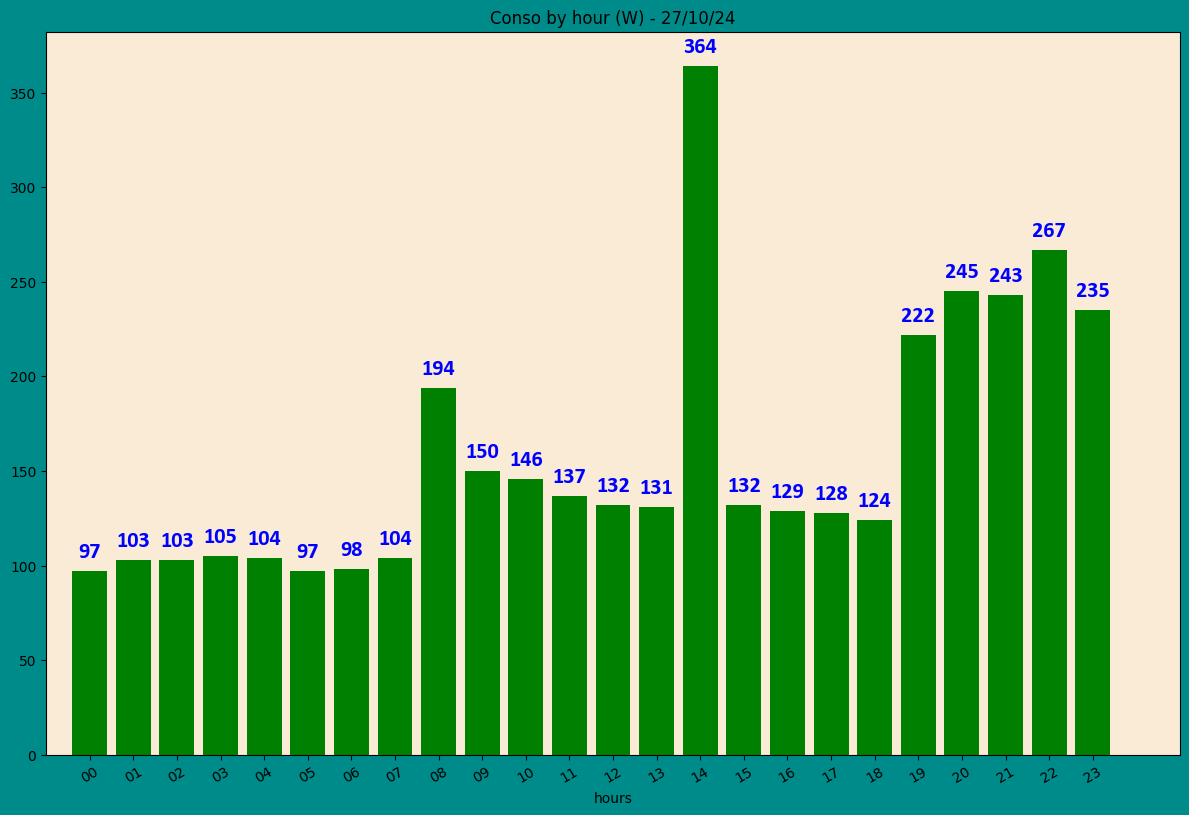

In [311]:
day = '27/10/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [312]:
month.describe()


,kWh
count,108446.000000
mean,0.334554
std,0.564583
min,0.090000
25%,0.120000
50%,0.140000
75%,0.190000
max,3.730000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

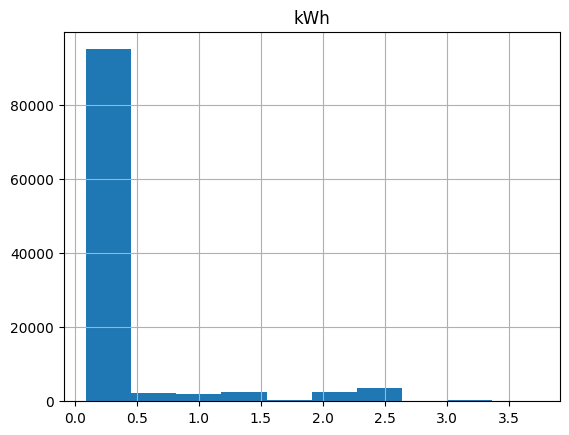

In [313]:
month.hist()

<Axes: >

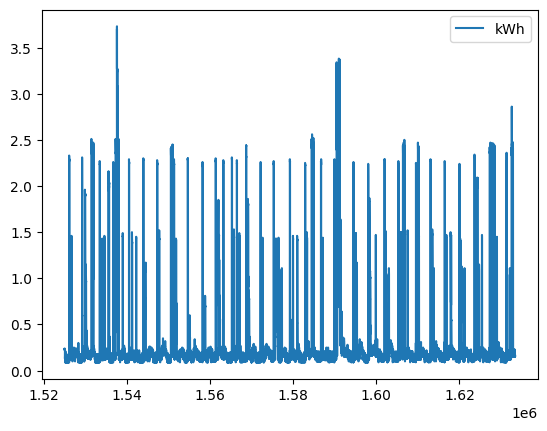

In [314]:
month.plot()

In [315]:
# index with max conso in this month
month.idxmax().kWh

1537642

In [316]:
# plot month day max conso (télévision de 11h à 23h)
day = month.idxmax()
#day = '27/10/2024'
day

day       1629876
hours     1528092
months    1524970
kWh       1537642
dtype: int64

In [317]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [318]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
21/08/23 21      97      97    NaN   NaN
         22     282     379  185.0   NaN
         23     152     531 -130.0   NaN
22/08/23 00     129     129    NaN   NaN
         01     130     259    1.0   NaN
...             ...     ...    ...   ...
09/03/25 18     290    3199  155.0  19.0
         19     276    3475  -14.0  20.0
         20     315    3790   39.0  21.0
         21     280    4070  -35.0  22.0
         22      66    4136 -214.0  23.0

[13586 rows x 4 columns]

In [319]:
month

,day,hours,months,kWh
1524970,01,00,2024-11,0.23
1524971,01,00,2024-11,0.23
1524972,01,00,2024-11,0.23
1524973,01,00,2024-11,0.23
1524974,01,00,2024-11,0.23
...,...,...,...,...
1633411,30,23,2024-11,0.16
1633412,30,23,2024-11,0.16
1633413,30,23,2024-11,0.16
1633414,30,23,2024-11,0.16


In [320]:
month.idxmax()


day       1629876
hours     1528092
months    1524970
kWh       1537642
dtype: int64

In [321]:
month.loc[month.idxmax().kWh]


day            04
hours          13
months    2024-11
kWh          3.73
Name: 1537642, dtype: object

In [322]:
grp_by_dayhours.loc[['28/02/25']].idxmax()

C:\Users\jean\AppData\Local\Temp\ipykernel_25696\4095454801.py:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  grp_by_dayhours.loc[['28/02/25']].idxmax()


kWh       (28/02/25, 20)
cumsum    (28/02/25, 23)
diff      (28/02/25, 08)
days                 NaN
dtype: object

In [323]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [324]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [325]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [326]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB